# Scraping euromomo data from the graphs

>EuroMOMO is a European mortality monitoring activity, aiming to detect and measure excess deaths related to seasonal influenza, pandemics and other public health threats.

>Official national mortality statistics are provided weekly from the 24 European countries in the EuroMOMO collaborative network, supported by the European Centre for Disease Prevention and Control (ECDC) and the World Health Organization (WHO).

## Graph data

They have data but it's not easy to access using normal means.

- they have repo with their model on [github](https://github.com/EuroMOMOnetwork/MOMO)
- it can be done using this  [pixel-scraper](https://github.com/browserdotsys/euromomo)


### But

1. I wanted the **raw** data for the graphs. 
1. The graphs are rendered dynamically using the **amazing** [Gatsby](https://www.gatsbyjs.org/).
1. This means you can't just dump the page source and scrape the data as text.


I'll got what I wanted by running a  [script](https://github.com/macbuse/COVID_stats/blob/master/ep.js)

```node ep.js```

You'll need to install [puppeteer](https://github.com/puppeteer/puppeteer) and have **node > 10.*** to do this.

The script **ep.js** emulates a user browsing the page - scrolling up and down to the graphs thus fooling the browser into executing all the **javascript** in the page and rendering the graphs. 


---

## What we are after: Z-score

This is the official [definition](https://www.euromomo.eu/how-it-works/what-is-a-z-score/)

In general, 

$ \text{Z-score} = \frac{(x-\text{mean of the population})}{(\text{Standard deviation of the population})}$

which could be approximated in our context by 

$ \text{S-score} = \frac{(\text{number of deaths - baseline})}{(\text{Standard deviation of residuals})}$

(variation of the number of deaths around the baseline) on the part of the series used to fit the model, used as the standard unit.

In [2]:
import pandas as pd

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cd /home/gregmcshane/CHROME/


/home/gregmcshane/CHROME


##originally...

I wanted to do this with [pyppeteer](https://github.com/miyakogi/pyppeteer)
but I ended up using javascript because I could just copy paste code from
the console in **Chrome's developer panel**.

The script dumps the **innerHtml** from each graph to a file **./graph*.html**
then I scrape the data using **regexp**.


```
re.compile('<h4>(.*?)<')      #country name
re.compile('[M|L]\d+,(\d+)')  #the path data
```



In [4]:
import re
cn = re.compile('<h4>(.*?)<')
pp = re.compile('[M|L]\d+,(\d+)')

graphs = {}

for k in range(1,25):
    with open('graph%d.html'%k, 'r') as fp:
        svg = fp.read()
    X = np.array([ int(x) for x in pp.findall(svg)])
    #I had to figure this out from the graphs
    #it actually changes depending on what age cat. you choose
    graphs[cn.search(svg).group(1)] =  X

# converting raw data

The curve data is a list of y-values as integers.
I need to rescale it to get to their **z-scores**.

In [95]:
from scipy import stats

X = min(graphs['Netherlands']), min(graphs['France']), min(graphs['UK (England)'])
Y = (10.13, 21.63, 42.34)
vv = stats.linregress( X, Y)


# Something wrong here this used to give the right slope

In [93]:
vv.slope, - 40/(80 - 7), vv.intercept,  80* 40/(80 - 7)

(0.03443951612903251,
 -0.547945205479452,
 24.863548387096774,
 43.83561643835616)

In [5]:
if False:
    for kk in graphs.keys():
        graphs[kk] = vv.slope * graphs[kk] +  vv.intercept
else:
    for kk in graphs.keys():
        graphs[kk] = (80 - graphs[kk]) * 40/(80 - 7)
     

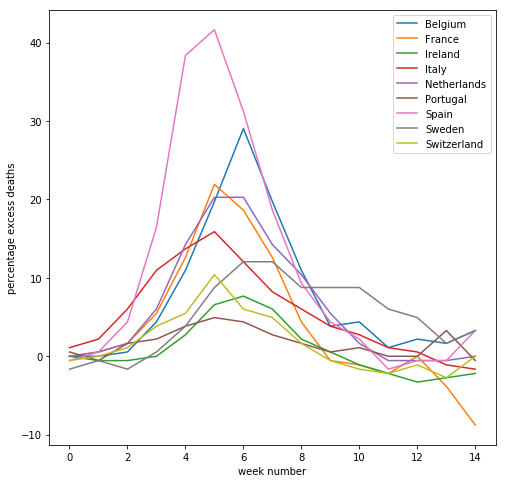

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

for kk in graphs.keys():
    if 'UK' in kk : continue
    dd = graphs[kk][-15:].astype(float)
    if max(dd) < 4 : continue
    if 'Germ' in kk : continue

    plt.plot(dd, label=kk)
    
plt.ylabel('percentage excess deaths')
plt.xlabel('week number')
leg = ax.legend()

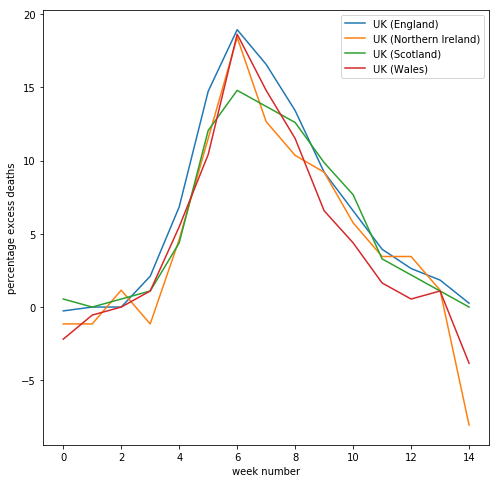

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

for kk in graphs.keys():
    if 'UK'  not in kk : continue
    dd = graphs[kk][-15:].astype(float)
    if 'Ire' in kk:
        dd *= 2.1
    if 'Eng' in kk:
        dd *= .48
    plt.plot(dd, label=kk)
    
plt.ylabel('percentage excess deaths')
plt.xlabel('week number')
leg = ax.legend()

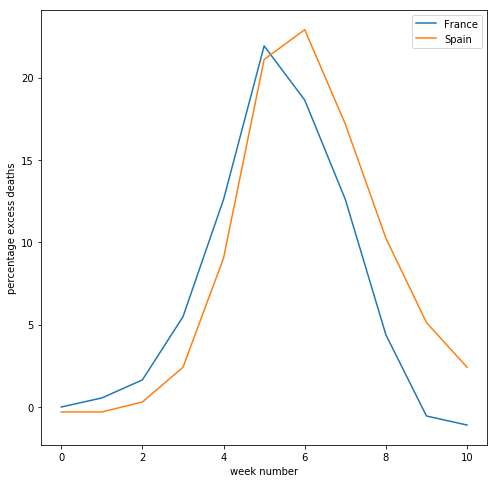

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

for kk,ff,dx in zip(['France', 'Spain'],[1., .55], [0,-1]):
    dd = graphs[kk][-15 + dx:-4 + dx].astype(float)
    dd *= ff
    plt.plot(dd, label=kk)
    
plt.ylabel('percentage excess deaths')
plt.xlabel('week number')
leg = ax.legend()

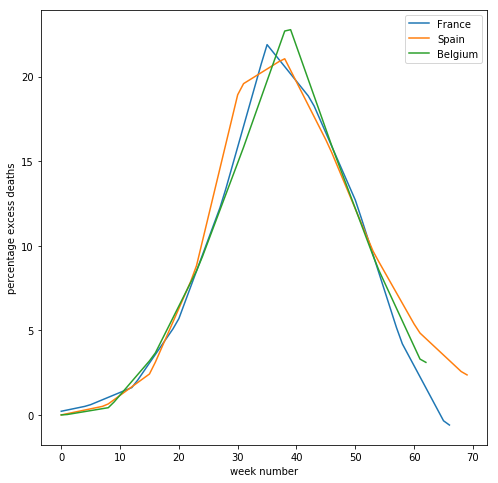

In [127]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

UU = {}

for kk,ff, dx in zip(['France', 'Spain','Belgium'],
                     [1., .5, .8], 
                     [3, 0, 7]):
    

    Y = graphs[kk][-15:-4].astype(float)
    # this is just to compare thngs
    Y *= ff
    # this is a hack to avoid negative values 
    # which will confuse np.log
    Y -= Y[0] + .001
    
    X = 7*np.linspace(0,11,11)
    pts = np.linspace(0,70,70) 
    YY = UU[kk] = np.interp(pts,X,Y)[dx:]
    
    plt.plot(YY, label=kk)
    
plt.ylabel('percentage excess deaths')
plt.xlabel('week number')
leg = ax.legend()


France 0.5730365697769848
Spain 0.578573133763357
Italy 0.5407277574558065
Belgium 0.6670260582263687
UK (England) 0.5362783199704085
Netherlands 0.5485737887168616


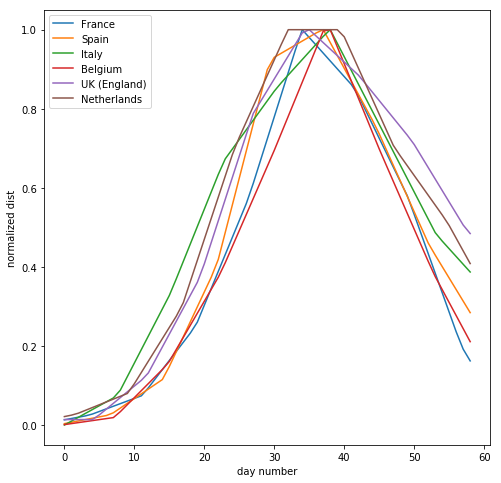

In [195]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

VV = {}

for kk in ['France', 'Spain','Italy', 'Belgium', 
           'UK (England)', 'Netherlands']:
    
    Y = graphs[kk][-15:-4].astype(float)
    # this is a hack to avoid negative values 
    # which will confuse np.log
    Y -= Y[0] + .001
    
    X = 7*np.linspace(0,11,11)
    pts = np.linspace(0,70,70) 
    YY = np.interp(pts,X,Y)
    
    dx = find_mean(YY)
    #print(kk, dx)
    
    YY = YY[dx - 37: dx + 22]
    YY /= max(YY)
    
    print(kk, sum(abs(YY[:38] - YY[38]))/37)
    
    VV[kk] = YY
    
    plt.plot(YY, label=kk)
    
plt.ylabel('normalized dist')
plt.xlabel('day number')
leg = ax.legend()


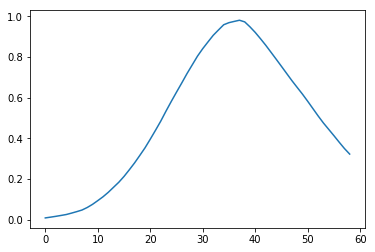

In [201]:
tt = sum([ y for y in VV.values()])

plt.plot(tt/6)

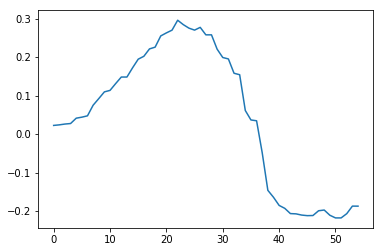

In [225]:
window = np.arange(0,2)
mm = [stats.linregress(window, tt[window + k]).slope for k in range(0,55) ]
 
plt.plot(mm)

In [186]:
def find_mean(Y):
    m = sum(Y)/2
    tt = np.cumsum(Y)
    return len(tt[tt < m])
    

36

In [150]:
def find_mean(Y):
    m = sum(Y)/2
    a, b = 0, len(Y) - 1
    c = int( .5*(a + b))
    for k in range(6):
        
        if sum(Y[:c]) > m:
            b = c
        else:
            a = c
        c = int( .5*(a + b))
    return c
    
find_mean(YY)

37

(LinregressResult(slope=0.16888794084872333, intercept=-0.5049049298025508, rvalue=0.9916840907549962, pvalue=8.731962333954205e-24, stderr=0.004383493712131567),
 4.1041839759347445)

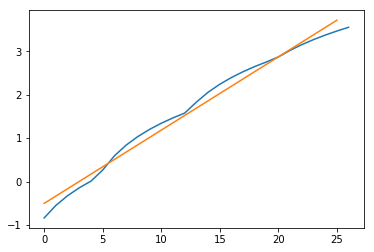

In [126]:
Y = np.log(UU['Spain'][3:30])

plt.plot(Y)
vv = stats.linregress(np.arange(len(Y)),Y)

xs = np.array([0,25])
ys = vv.slope*xs + vv.intercept
plt.plot(xs, ys)

vv, np.log(2)/vv.slope

# Comparing just 2 countries

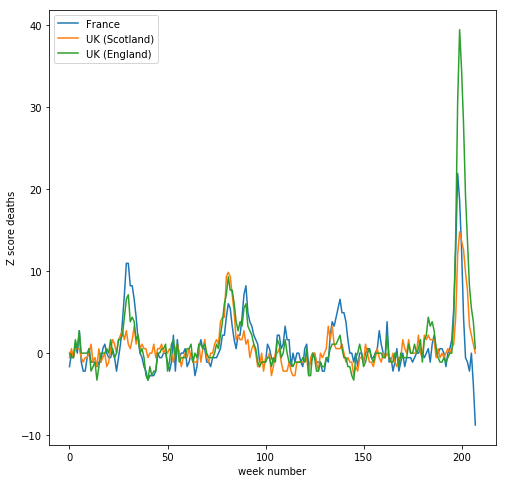

In [194]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

for kk in ['France', 
           'UK (Scotland)',
           'UK (England)',
           #'Italy'
           #'Netherlands'
          ]:
    
    dd = graphs[kk][:]
    if max(dd) < 5: continue
    plt.plot(dd, label=kk)
    #plt.plot((1 + dd/100)*1800*7, label=kk)
    
plt.ylabel('Z score deaths')
plt.xlabel('week number')
leg = ax.legend()

40.54794520547946
63.56164383561644
33.424657534246585
64.10958904109589


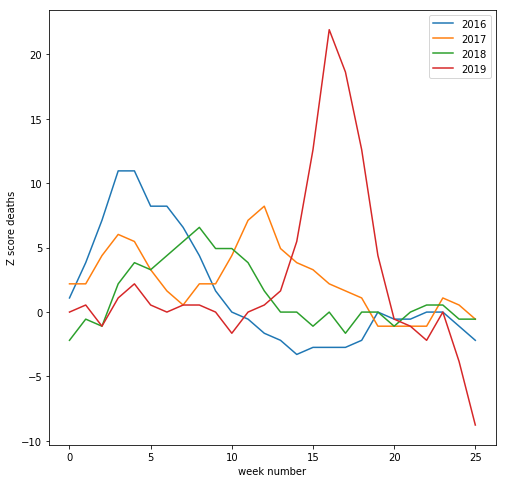

In [9]:

#they count the flu season as starting the previous year
labels = [str(2016 + k) for k in range(5)]


fig, ax = plt.subplots()
fig.set_size_inches(8,8)

FF = graphs['France']
uu = len(FF)
for k in [0,1,2,3]:
    tt = FF[52*k + 26 :52*k + 52]
    plt.plot(tt, label=labels[k] )
    print(sum(tt))
    
plt.ylabel('Z score deaths')
plt.xlabel('week number')
leg = ax.legend()

In [12]:
3*sum(graphs['France'][-12:]*1500/100)*7

18641.09589041096

# Comparing with raw data from INSEE

>During the Covid-19 pandemic, INSEE is reporting the number of deaths per day per department on a weekly basis. Deaths are recorded in the commune in which they occur (and not in the place of residence of the deceased). The statistics released are provisional (please see the methodological note (in French)). The CSV file containing the (non-personal) data regarding each death is also updated weekly.


They give away data [here](https://www.insee.fr/fr/statistiques/4487988?sommaire=4487854).
I think I manually downloaded this but I should it.


<script id="gatsby-script-loader">/*<![CDATA[*/window.pagePath="/graphs-and-maps";/*]]>*/</script>

In [11]:
df = pd.read_csv('2020-06-12_deces_quotidiens_departement_csv.csv', sep=';')
df[:3]

,Date_evenement,Zone,Communes_a_envoi_dematerialise_Deces2020,Total_deces_2020,Communes_a_envoi_dematerialise_Deces2019,Total_deces_2019,Communes_a_envoi_dematerialise_Deces2018,Total_deces_2018
0,01-mars,France,1625.0,1778.0,1708,1872,1928,2136
1,02-mars,France,3263.0,3559.0,3467,3782,3933,4327
2,03-mars,France,4896.0,5326.0,5034,5530,5881,6455


In [12]:
cutoff = 92
df[90:100]

,Date_evenement,Zone,Communes_a_envoi_dematerialise_Deces2020,Total_deces_2020,Communes_a_envoi_dematerialise_Deces2019,Total_deces_2019,Communes_a_envoi_dematerialise_Deces2018,Total_deces_2018
90,30-mai,France,161304.0,175953.0,137450,150331,143272,157217
91,31-mai,France,162550.0,177307.0,138874,151887,144634,158702
92,01-juin,France,163832.0,178706.0,140329,153461,146002,160178
93,02-juin,France,165152.0,NaN,141750,155016,147413,161715
94,03-juin,France,166422.0,NaN,143228,156624,148787,163235
95,04-juin,France,167711.0,NaN,144658,158194,150158,164740
96,05-juin,France,168814.0,NaN,146044,159705,151489,166180
97,06-juin,France,NaN,NaN,147428,161201,152831,167656
98,07-juin,France,NaN,NaN,148778,162683,154164,169124
99,08-juin,France,NaN,NaN,150127,164166,155592,170692


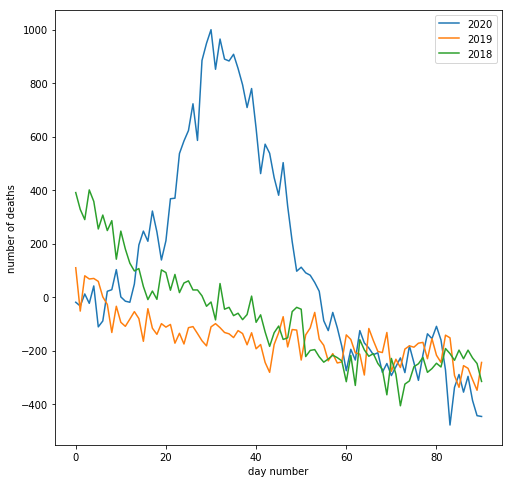

In [13]:
labels = [str(2018 + k) for k in range(3)]

fig, ax = plt.subplots()
fig.set_size_inches(8,8)


for k in [3,5,7]:
    XX = df.iloc[:cutoff,k]
    plt.plot(np.diff(XX) - 1800, label=labels.pop())
    
plt.ylabel('number of deaths')
plt.xlabel('day number')
leg = ax.legend()

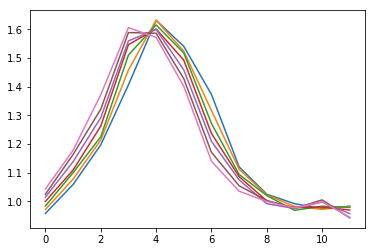

In [15]:
XX = np.diff( df.iloc[:cutoff,3]) / np.diff( df.iloc[:cutoff,5]) #compare days from 2020 and 2019
CX = np.convolve(XX, np.ones((7,))/7, mode='valid')  #rolling average

#do a number of plots with different phases 'a'
for a in range(7):
    plt.plot( [CX[7*k + a] for k in np.arange(int(cutoff/7)-1)]) #plot a sample - every 7th day

# Z-score

This is the official [definition](https://www.euromomo.eu/how-it-works/what-is-a-z-score/)

In general, 

$ \text{Z-score} = \frac{(x-\text{mean of the population})}{(\text{Standard deviation of the population})}$

which could be approximated in our context by 

$ \text{S-score} = \frac{(\text{number of deaths - baseline})}{(\text{Standard deviation of residuals})}$

(variation of the number of deaths around the baseline) on the part of the series used to fit the model, used as the standard unit.

---

I'll plot their S-score for France and fit the data from the INSEE by hand.

- I think this means that they are claiming a SD of .333 for the data for France
- I could do a better fit using least squares 

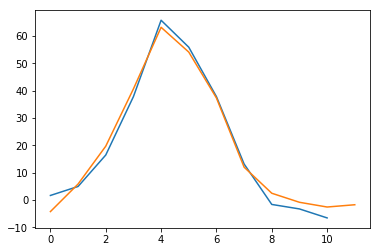

In [18]:
plt.plot( 3*graphs['France'][-14:-3]) # shouldn't hard code this range - 
plt.plot( [100*(CX[7*k] - 1) for k in np.arange(int(cutoff/7)-1)])